In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and Dataset Path

In [81]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
import scipy.signal as sig
from keras.utils import np_utils
from keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU


from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [3]:
data_path = "/content/drive/MyDrive/Atraining_normal (1)/Atraining_normal/"


# Analyzing the Heart Beat Sound 

In [4]:
# Listen to random audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class))) 
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

In [5]:
# show waveform of audio from dataset 
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveshow(audio_sample, sr = 22050)
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [6]:
# show spectrum of audio from dataset 
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [7]:
# show specrogram of audio from dataset 
# the output is an image that represents a sound. 
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

In [8]:
normal_audio, normal_sample  = random_sound(data_path)
normal_audio

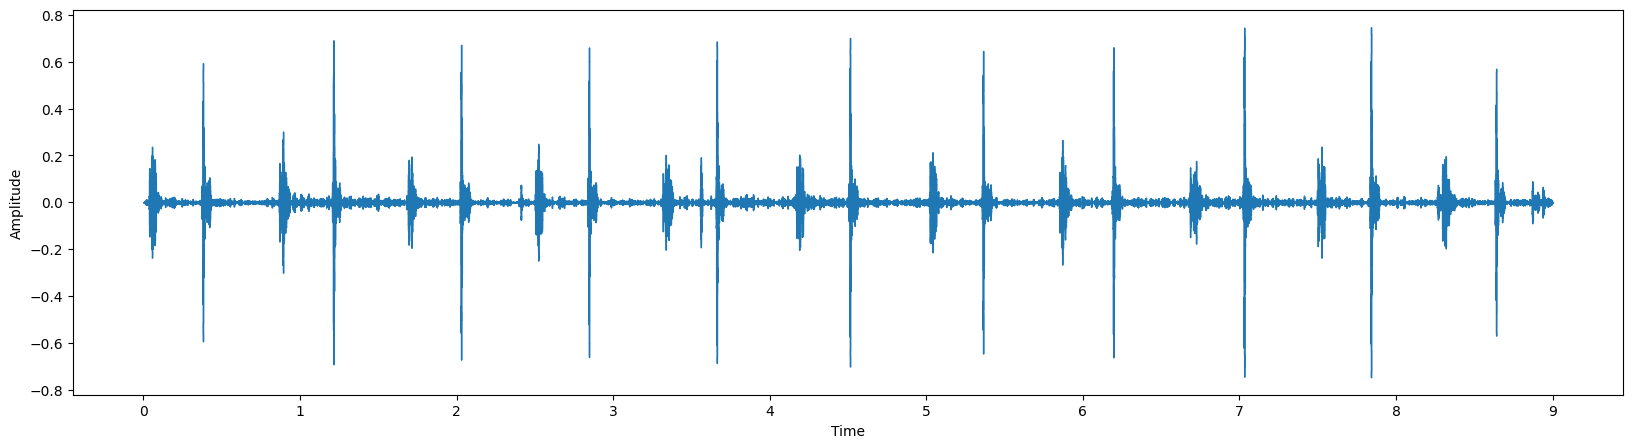

In [9]:
show_audio_waveform(normal_sample)

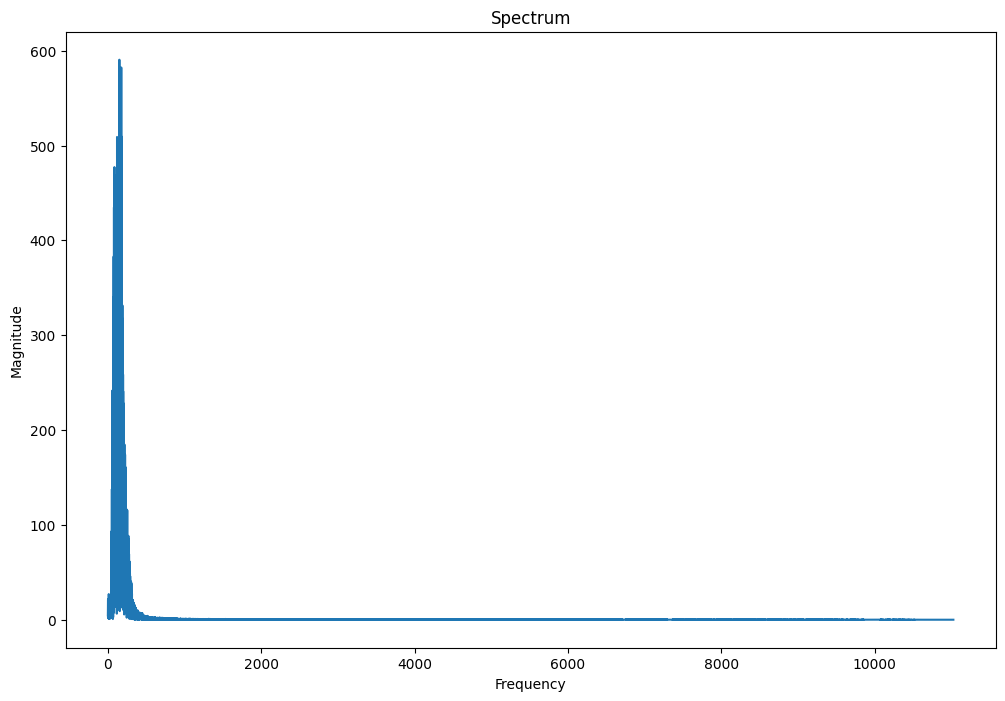

In [10]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


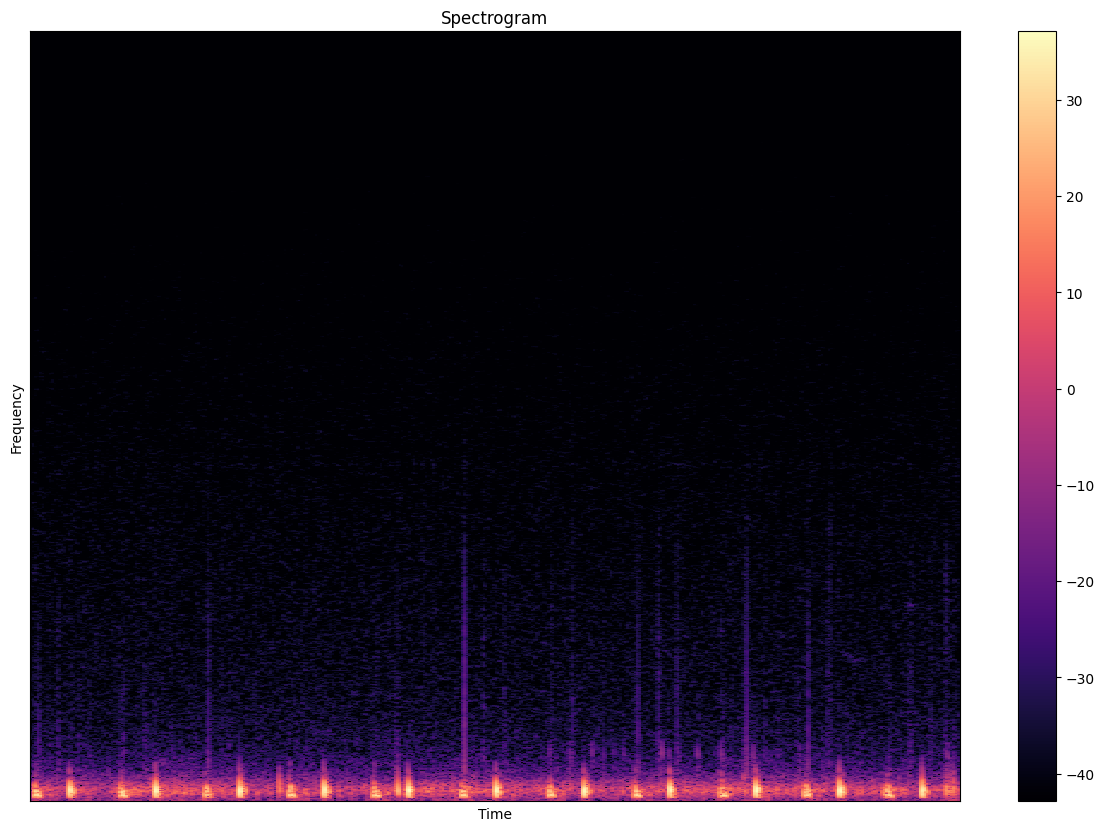

In [11]:
show_spectrogram(normal_sample)

# Taking an example audio signal

In [82]:
data, sr = librosa.load('/content/drive/MyDrive/Atraining_normal (1)/Atraining_normal/201105021804.wav', sr=None, mono=True)

Performing Wavelet Decomposition

This code performs a wavelet decomposition of a signal called normal_sample using the "db1" wavelet with a decomposition level of 4. The resulting wavelet coefficients are then reconstructed using the same wavelet.

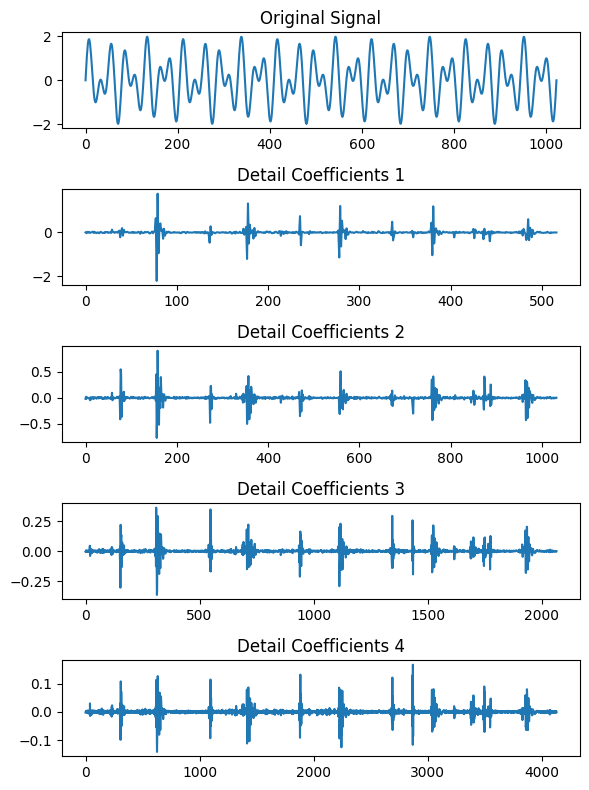

In [83]:
import pywt
import numpy as np
# perform wavelet decomposition
coeffs = pywt.wavedec(normal_sample, 'db1', level=4)
x_reconstructed = pywt.waverec(coeffs, 'db1')
# plot the results
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(6, 8))
axs[0].plot(y)
axs[0].set_title('Original Signal')
for i, ax in enumerate(axs[1:], start=1):
    ax.plot(coeffs[i])
    ax.set_title(f'Detail Coefficients {i}')
plt.tight_layout()
plt.show()

In [20]:
normal_sample, sr = librosa.load('/content/drive/MyDrive/Atraining_normal (1)/Atraining_normal/201105021804.wav', sr=None, mono=True)

# Signal Decimation 
Signal decimation is the process of reducing the sampling rate of a signal by removing a portion of its samples while preserving its important information. In other words, it involves downsampling the signal by reducing the number of samples that represent the signal.

Decimation is useful in signal processing applications where the signal's high-frequency content is not required. For example, in digital audio applications, decimation can be used to reduce the amount of data required to store or transmit an audio signal, thereby reducing storage or transmission requirements.

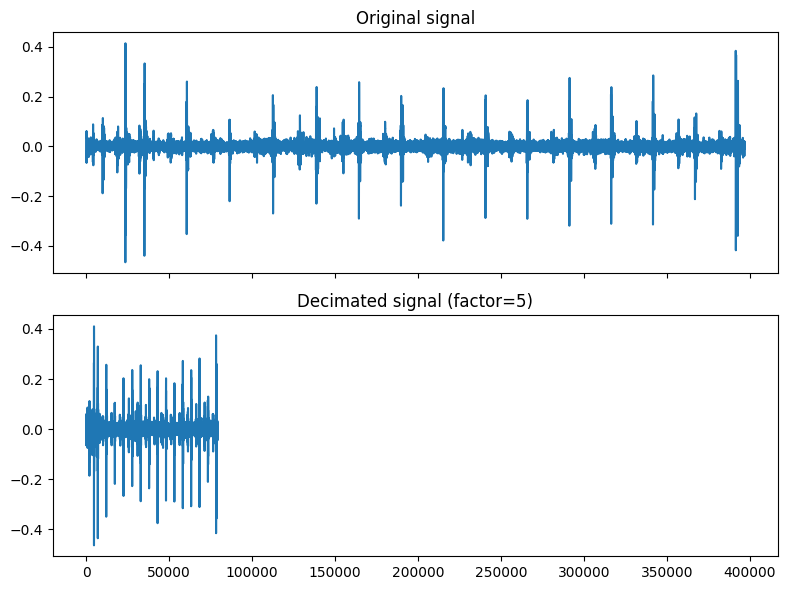

In [21]:
# Decimate the signal with a factor of 5 using decimate function
decimated_signal = sig.decimate(normal_sample, q=5)

# Alternatively, we can perform decimation using resample function
# Note that resample requires the original and desired sample rates
original_sample_rate = 1000
desired_sample_rate = original_sample_rate/5
resampled_signal = sig.resample(normal_sample, int(len(normal_sample)/5))

# Plot the original and decimated signals for comparison
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(normal_sample)
ax1.set_title('Original signal')

ax2.plot(decimated_signal)
ax2.set_title('Decimated signal (factor=5)')

plt.tight_layout()
plt.show()

A Butterworth band-pass filter is a type of filter that allows a certain range of frequencies to pass through the filter while attenuating frequencies outside of that range. The Butterworth filter is a type of IIR (infinite impulse response) filter that has a maximally flat frequency response in the passband, meaning that the gain of the filter in the passband is as constant as possible across the passband.

A band-pass filter is a type of filter that allows a specific range of frequencies to pass through the filter, while attenuating frequencies outside of that range. A Butterworth band-pass filter is therefore a filter that has the Butterworth frequency response characteristic and is designed to pass a certain range of frequencies.

The resulting filtered signal should contain only frequencies between the low and high cutoff frequencies, which in this case are 20 Hz and 30 Hz respectively.

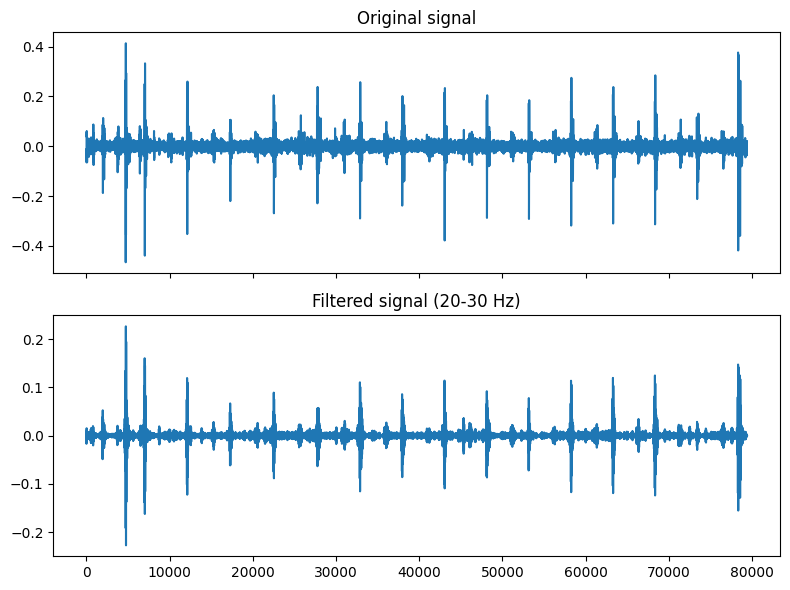

In [22]:
# Define the filter parameters
lowcut = 20  # Hz
highcut = 30  # Hz
fs = 1000  # Hz
order = 4

# Calculate the Nyquist frequency
nyquist = 0.5 * fs

# Normalize the cutoff frequencies
low = lowcut / nyquist
high = highcut / nyquist

# Design a Butterworth band-pass filter
b, a = sig.butter(order, [low, high], btype='band')

# Apply the filter to the signal using filtfilt
filtered_signal = sig.filtfilt(b, a, resampled_signal)

# Plot the original and filtered signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(resampled_signal)
ax1.set_title('Original signal')

ax2.plot(filtered_signal)
ax2.set_title('Filtered signal ({}-{} Hz)'.format(lowcut, highcut))

plt.tight_layout()
plt.show()

A Chebyshev Type I filter is a type of analog or digital filter that is designed to have a sharper cutoff between the passband and the stopband compared to a Butterworth filter of the same order. Chebyshev filters are characterized by ripples in the passband or stopband, depending on the type of Chebyshev filter (Type I or Type II).

A fifth-order Chebyshev Type I lowpass filter is designed with a passband frequency of 100 Hz and a stopband frequency of 882 Hz. The filter is applied to the previously filtered signal using filtfilt function. The resulting signal is a low-pass filtered version of the original signal. The filtered signal is plotted along with the original signal for comparison.

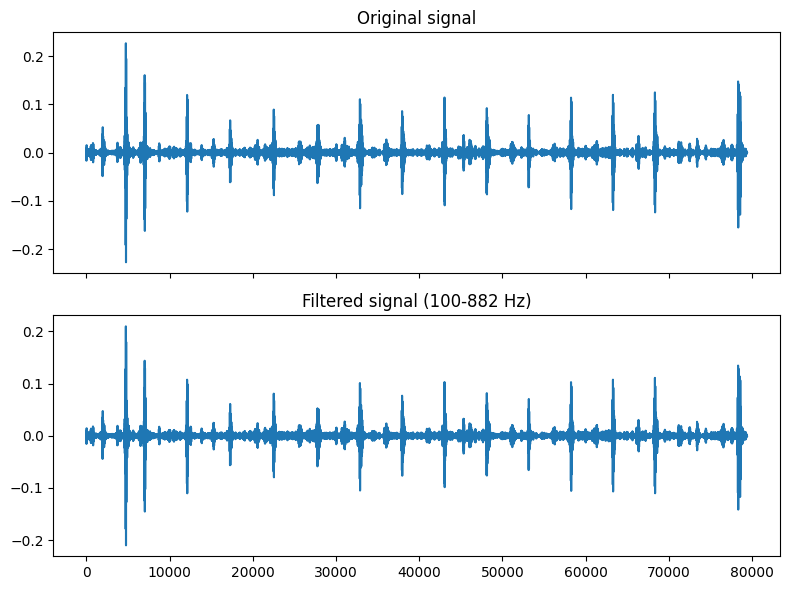

In [23]:
# Define the filter parameters
fs = 2000  # Hz
lowcut = 100  # Hz
highcut = 882  # Hz
nyquist = 0.5 * fs
passband = lowcut / nyquist
stopband = highcut / nyquist
order = 5

# Design a fifth-order Chebyshev Type I lowpass filter
b, a = sig.cheby1(order, 1, passband)

# Apply the filter to the signal using filtfilt
low_filtered_signal = sig.filtfilt(b, a, filtered_signal)

# Plot the original and filtered signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(filtered_signal)
ax1.set_title('Original signal')

ax2.plot(low_filtered_signal)
ax2.set_title('Filtered signal ({}-{} Hz)'.format(lowcut, highcut))

plt.tight_layout()
plt.show()

Signal Normalization

In [24]:
normalized_signal = low_filtered_signal / np.max(np.abs(low_filtered_signal))

print(normalized_signal)

[-0.00052527 -0.01286847 -0.02494979 ... -0.00020682 -0.00036487
 -0.00050317]


The below code calculates the Shannon envelope of a normalized signal using the Hilbert transform.

The Hilbert transform is a mathematical operation that takes a real-valued signal and produces a complex-valued signal, where the real part is the original signal and the imaginary part is the Hilbert transform. The Hilbert transform is used to obtain the analytic signal, which has a unique property of having a positive frequency spectrum.

The Shannon envelope is defined as the magnitude of the analytic signal. It is named after Claude Shannon, who used the Hilbert transform to study the bandwidth of a signal.

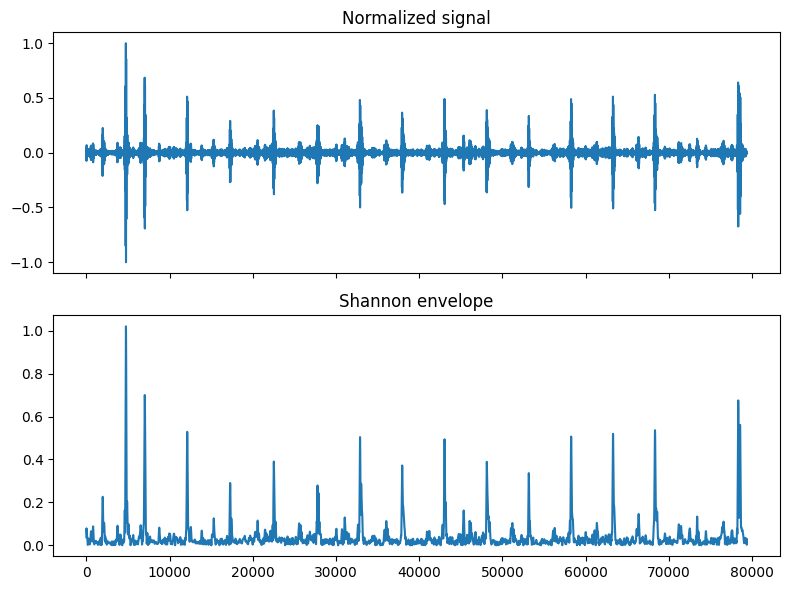

In [25]:
analytic_signal = sig.hilbert(normalized_signal)

# Calculate the absolute value of the analytic signal
envelope = np.abs(analytic_signal)

# Plot the original and envelope signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(normalized_signal)
ax1.set_title('Normalized signal')

ax2.plot(envelope)
ax2.set_title('Shannon envelope')

plt.tight_layout()
plt.show()

The Below code calculates the average energy of a signal in overlapping windows of a specified size using the Hilbert transform and Shannon envelope.

The first part of the code calculates the window size and overlap size in samples based on the example sample rate of 1000 Hz. The Hilbert transform is then applied to the normalized signal to obtain the analytic signal, which is used to calculate the Shannon envelope.

The next part of the code calculates the energy in each window by squaring the envelope and summing over each window. The energy is then divided by the window size to obtain the average energy in each window. The results are printed to the console

In [26]:
# Set window size and overlap
window_size = 0.02  # in seconds
overlap_size = 0.01  # in seconds

# Calculate window size and overlap in samples
sample_rate = 1000  # example sample rate in Hz
window_size_samples = int(window_size * sample_rate)
overlap_size_samples = int(overlap_size * sample_rate)

# Calculate the Hilbert transform of the signal
analytic_signal = sig.hilbert(normalized_signal)

# Calculate the absolute value of the analytic signal
envelope = np.abs(analytic_signal)

# Calculate the energy in each window
energy = np.zeros(len(normalized_signal))
for i in range(0, len(normalized_signal) - window_size_samples + 1, overlap_size_samples):
    energy[i:i+window_size_samples] = np.sum(envelope[i:i+window_size_samples]**2)

# Calculate the average energy in each window
average_energy = energy / window_size_samples

# Print the results
print(average_energy)

[0.00500824 0.00500824 0.00500824 ... 0.00020523 0.00020523 0.00020523]


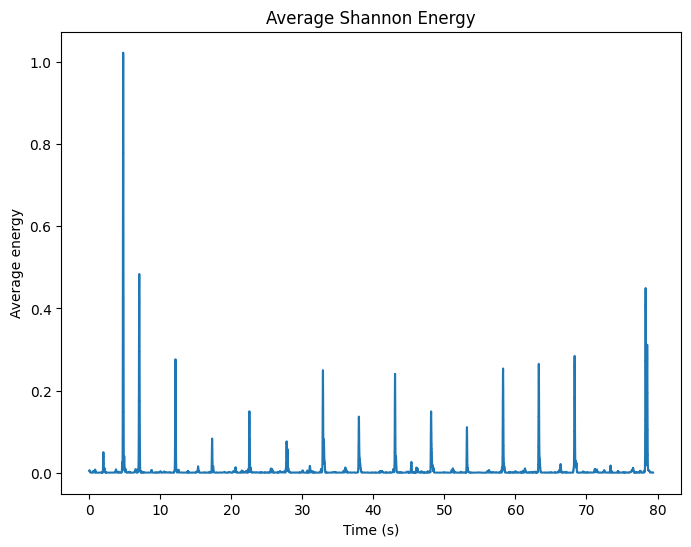

In [27]:
# Plot the average energy
time = np.arange(len(normalized_signal)) / sample_rate
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, average_energy)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average energy')
ax.set_title('Average Shannon Energy')
plt.show()

This code finds peaks in the average Shannon energy of a signal and filters out peaks below a certain threshold value. Here's a breakdown of what each line does:

* peaks, _ = sig.find_peaks(average_energy, distance=interval*1000/2): 
This uses the find_peaks() function from the scipy.signal module to find all the peaks in the average_energy array. The distance argument specifies the minimum distance between adjacent peaks, in samples. Here, it is set to half the interval between windows, converted to samples.
* peak_values = average_energy[peaks]: This extracts the values of average_energy at the peak indices.
peak_mask = peak_values >= 0.2: This creates a boolean mask that is True at the indices where the peak_values are greater than or equal to 0.2.
* filtered_peaks = peaks[peak_mask]: This applies the peak_mask to the peaks array to filter out any peaks below the threshold. The resulting array filtered_peaks contains only the indices of the peaks that passed the filter.
* time = np.arange(len(average_energy)) / sample_rate: This creates an array of time values corresponding to each sample in the average_energy array.
* fig, ax = plt.subplots(figsize=(8, 6)): This creates a new Matplotlib figure with a single axis.
* ax.plot(time, average_energy): This plots the average_energy array on the axis.
* ax.plot(time[filtered_peaks], average_energy[filtered_peaks], 'x', color='red', markersize=10, label='Filtered peaks'): This plots red x markers at the times corresponding to the filtered peaks on the same axis, with a label.
* ax.set_xlabel('Time (s)'): This sets the x-axis label.
* ax.set_ylabel('Average energy'): This sets the y-axis label.
* ax.set_title('Average Shannon Energy'): This sets the plot title.
* ax.legend(): This adds a legend to the plot.
* plt.show(): This displays the plot.

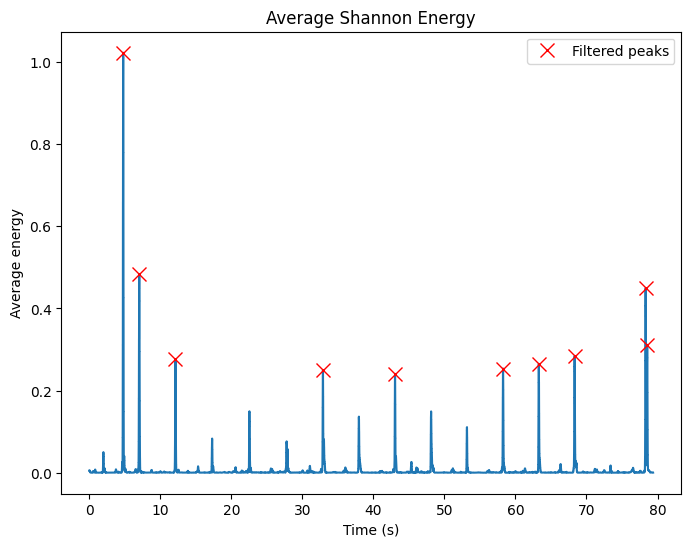

In [28]:
peaks, _ = sig.find_peaks(average_energy, distance=interval*1000/2)
# Filter peaks above 0.2
peak_values = average_energy[peaks]
peak_mask = peak_values >= 0.2
filtered_peaks = peaks[peak_mask]

# Plot the average energy and the filtered peaks
time = np.arange(len(average_energy)) / sample_rate
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, average_energy)
ax.plot(time[filtered_peaks], average_energy[filtered_peaks], 'x', color='red', markersize=10, label='Filtered peaks')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average energy')
ax.set_title('Average Shannon Energy')
ax.legend()
plt.show()

Below is the generated output which we will verify this output with the corresponding S1, S2 values in the Atraining_normal_seg.csv file.

In [29]:
filtered_peaks

array([ 4744,  7014, 12114, 32874, 43034, 58244, 63284, 68324, 78324,
       78544])

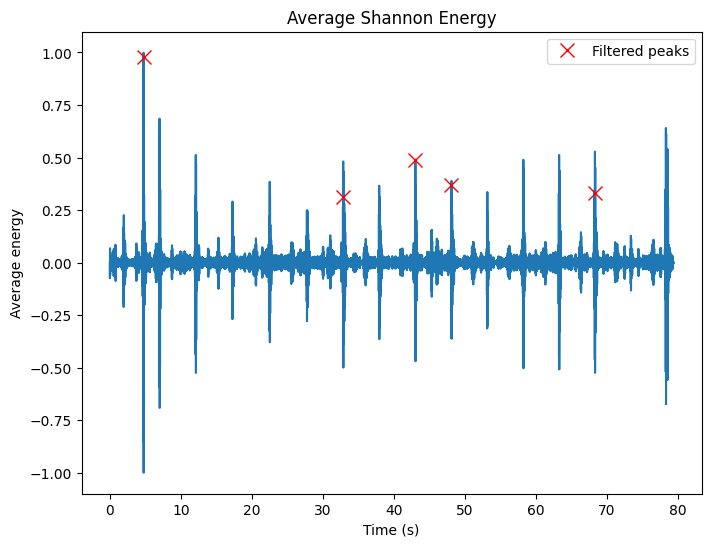

In [30]:
# Filter peaks above 0.2
peak_values = normalized_signal[peaks]
peak_mask = peak_values >= 0.3
filtered_peaks = peaks[peak_mask]

# Plot the average energy and the filtered peaks
time = np.arange(len(normalized_signal)) / sample_rate
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, normalized_signal)
ax.plot(time[filtered_peaks], normalized_signal[filtered_peaks], 'x', color='red', markersize=10, label='Filtered peaks')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average energy')
ax.set_title('Average Shannon Energy')
ax.legend()
plt.show()

In [31]:
filtered_peaks

array([ 4744, 32874, 43034, 48114, 68324])

In [32]:
data_path = "/content/drive/MyDrive/Btraining_normal/Training B Normal/"

In [33]:
normal_audio, normal_sample  = random_sound(data_path)
normal_audio

In [34]:
normal_sample, sr = librosa.load('/content/drive/MyDrive/Btraining_normal/Training B Normal/125_1306332456645_B.wav', sr=None, mono=True)

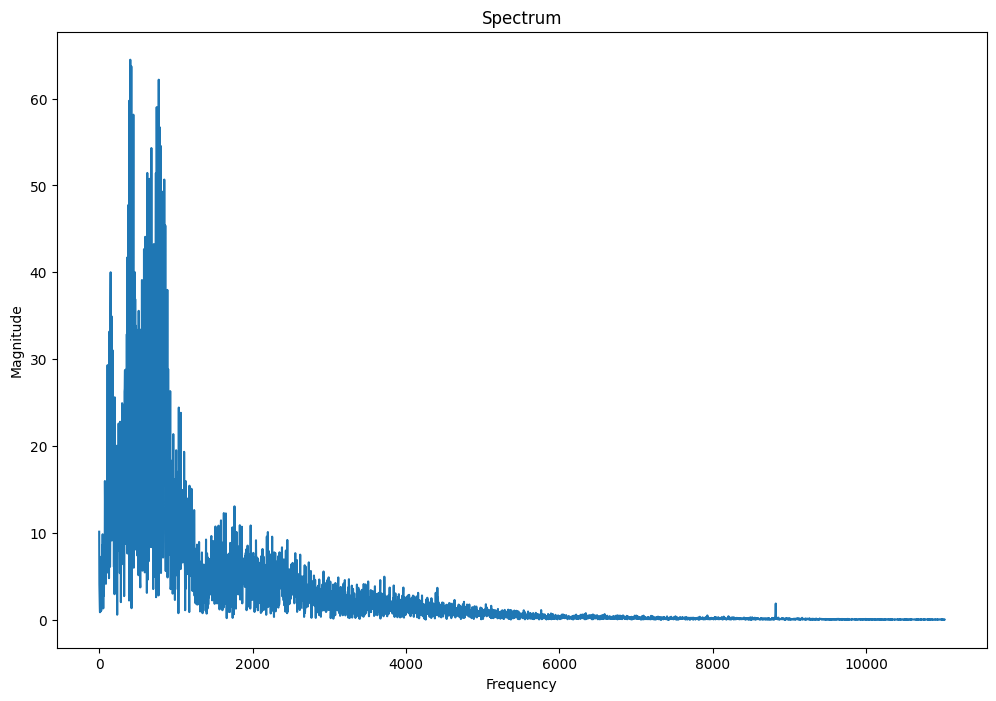

In [35]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


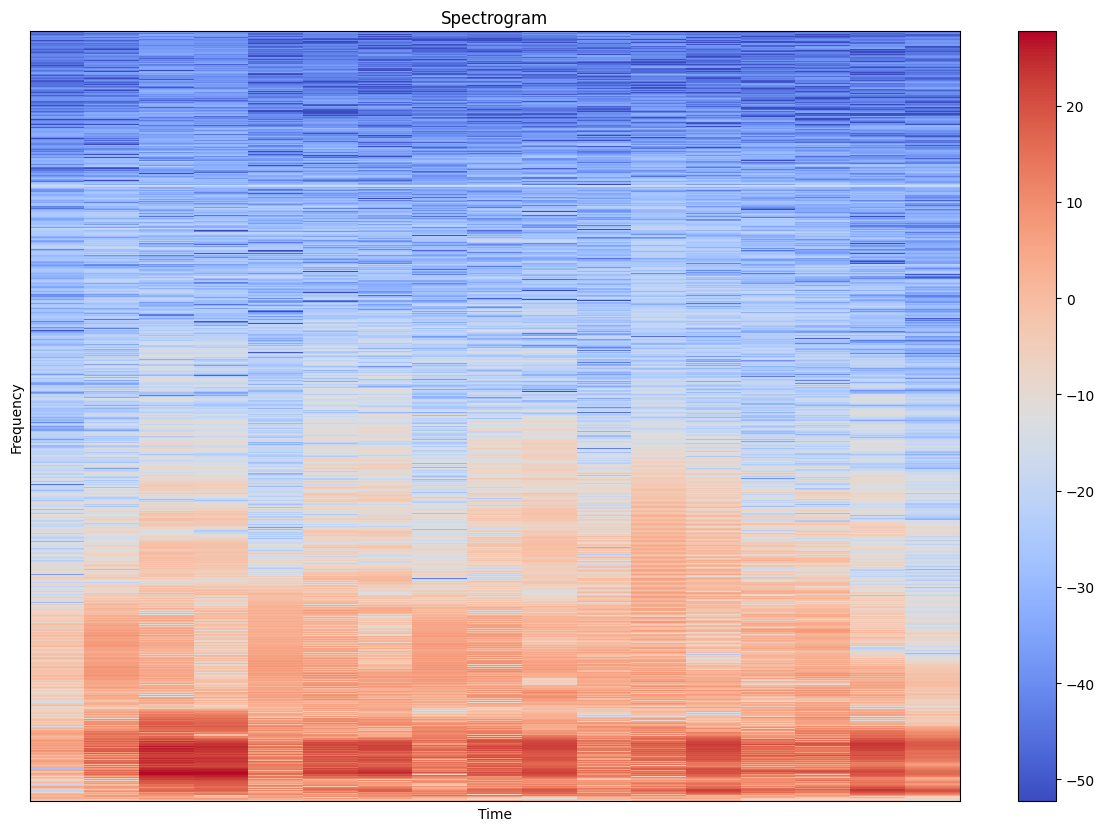

In [36]:
show_spectrogram(normal_sample)

In [37]:
normal_sample, sr = librosa.load('/content/drive/MyDrive/Btraining_normal/Training B Normal/125_1306332456645_B.wav', sr=None, mono=True)

Signal decimation is the process of reducing the sampling rate of a signal by removing a portion of its samples while preserving its important information. In other words, it involves downsampling the signal by reducing the number of samples that represent the signal.

Decimation is useful in signal processing applications where the signal's high-frequency content is not required. For example, in digital audio applications, decimation can be used to reduce the amount of data required to store or transmit an audio signal, thereby reducing storage or transmission requirements.

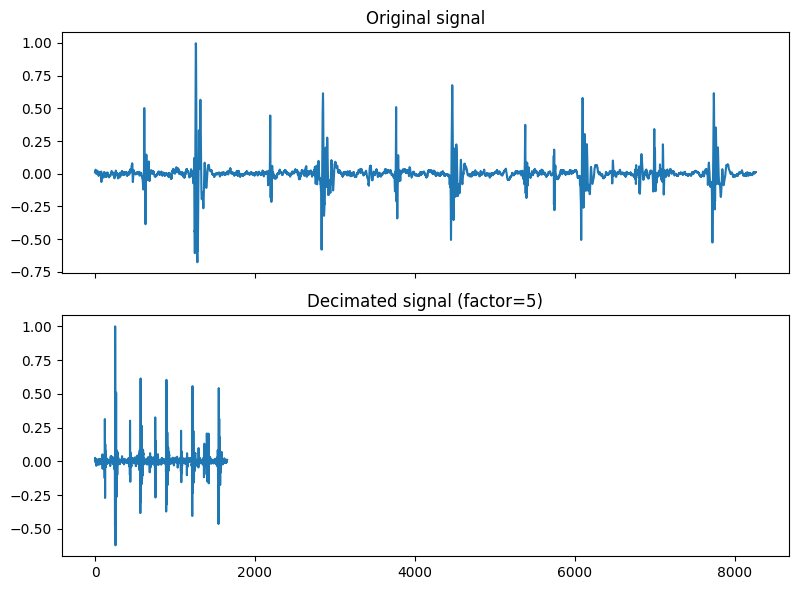

In [38]:
# Decimate the signal with a factor of 5 using decimate function
decimated_signal = sig.decimate(normal_sample, q=5)

# Alternatively, we can perform decimation using resample function
# Note that resample requires the original and desired sample rates
original_sample_rate = 1000
desired_sample_rate = original_sample_rate/5
resampled_signal = sig.resample(normal_sample, int(len(normal_sample)/5))

# Plot the original and decimated signals for comparison
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(normal_sample)
ax1.set_title('Original signal')

ax2.plot(decimated_signal)
ax2.set_title('Decimated signal (factor=5)')

plt.tight_layout()
plt.show()

A Butterworth band-pass filter is a type of filter that allows a certain range of frequencies to pass through the filter while attenuating frequencies outside of that range. The Butterworth filter is a type of IIR (infinite impulse response) filter that has a maximally flat frequency response in the passband, meaning that the gain of the filter in the passband is as constant as possible across the passband.

A band-pass filter is a type of filter that allows a specific range of frequencies to pass through the filter, while attenuating frequencies outside of that range. A Butterworth band-pass filter is therefore a filter that has the Butterworth frequency response characteristic and is designed to pass a certain range of frequencies.

The resulting filtered signal should contain only frequencies between the low and high cutoff frequencies, which in this case are 20 Hz and 30 Hz respectively.

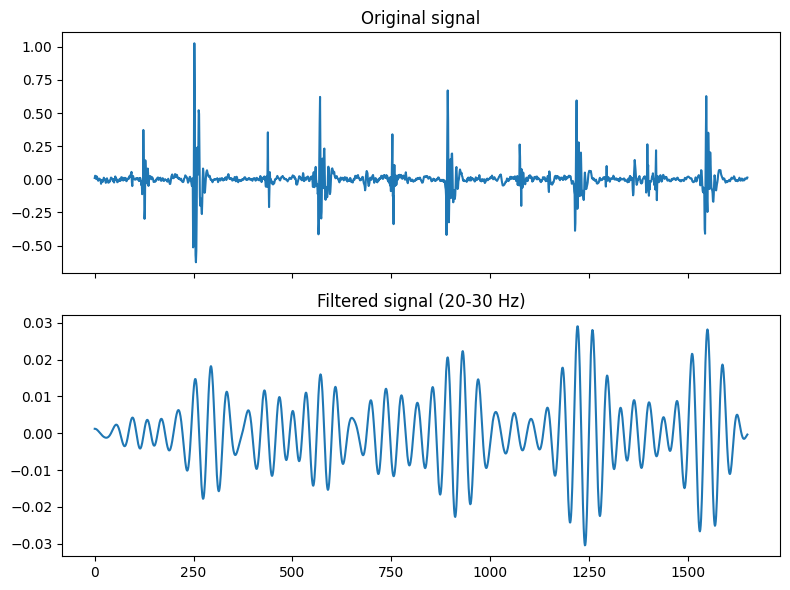

In [39]:
# Define the filter parameters
lowcut = 20  # Hz
highcut = 30  # Hz
fs = 1000  # Hz
order = 4

# Calculate the Nyquist frequency
nyquist = 0.5 * fs

# Normalize the cutoff frequencies
low = lowcut / nyquist
high = highcut / nyquist

# Design a Butterworth band-pass filter
b, a = sig.butter(order, [low, high], btype='band')

# Apply the filter to the signal using filtfilt
filtered_signal = sig.filtfilt(b, a, resampled_signal)

# Plot the original and filtered signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(resampled_signal)
ax1.set_title('Original signal')

ax2.plot(filtered_signal)
ax2.set_title('Filtered signal ({}-{} Hz)'.format(lowcut, highcut))

plt.tight_layout()
plt.show()

A Chebyshev Type I filter is a type of analog or digital filter that is designed to have a sharper cutoff between the passband and the stopband compared to a Butterworth filter of the same order. Chebyshev filters are characterized by ripples in the passband or stopband, depending on the type of Chebyshev filter (Type I or Type II).

A fifth-order Chebyshev Type I lowpass filter is designed with a passband frequency of 100 Hz and a stopband frequency of 882 Hz. The filter is applied to the previously filtered signal using filtfilt function. The resulting signal is a low-pass filtered version of the original signal. The filtered signal is plotted along with the original signal for comparison.

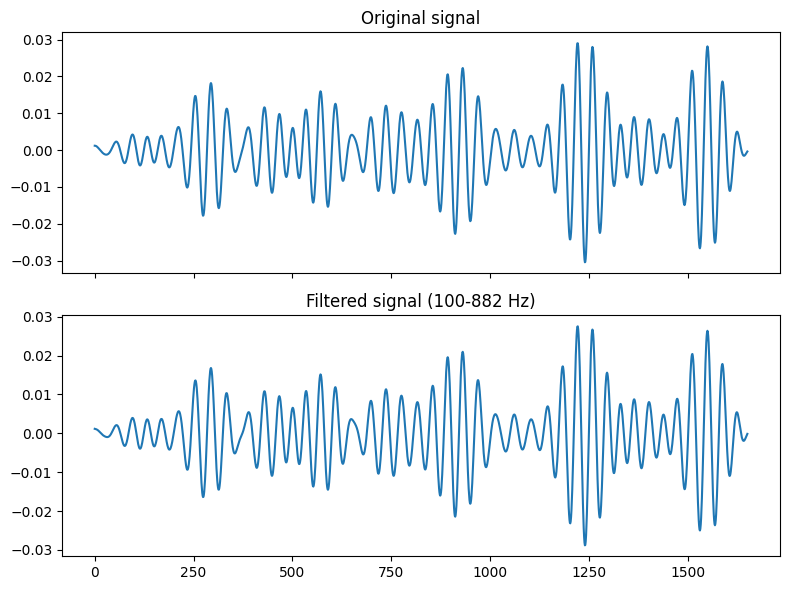

In [40]:
# Define the filter parameters
fs = 2000  # Hz
lowcut = 100  # Hz
highcut = 882  # Hz
nyquist = 0.5 * fs
passband = lowcut / nyquist
stopband = highcut / nyquist
order = 5

# Design a fifth-order Chebyshev Type I lowpass filter
b, a = sig.cheby1(order, 1, passband)

# Apply the filter to the signal using filtfilt
low_filtered_signal = sig.filtfilt(b, a, filtered_signal)

# Plot the original and filtered signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(filtered_signal)
ax1.set_title('Original signal')

ax2.plot(low_filtered_signal)
ax2.set_title('Filtered signal ({}-{} Hz)'.format(lowcut, highcut))

plt.tight_layout()
plt.show()

In [41]:
normalized_signal = low_filtered_signal / np.max(np.abs(low_filtered_signal))

print(normalized_signal)

[ 0.03971009  0.03883896  0.03792603 ... -0.02144377 -0.01313703
 -0.00540988]


The below code calculates the Shannon envelope of a normalized signal using the Hilbert transform.

The Hilbert transform is a mathematical operation that takes a real-valued signal and produces a complex-valued signal, where the real part is the original signal and the imaginary part is the Hilbert transform. The Hilbert transform is used to obtain the analytic signal, which has a unique property of having a positive frequency spectrum.

The Shannon envelope is defined as the magnitude of the analytic signal. It is named after Claude Shannon, who used the Hilbert transform to study the bandwidth of a signal.

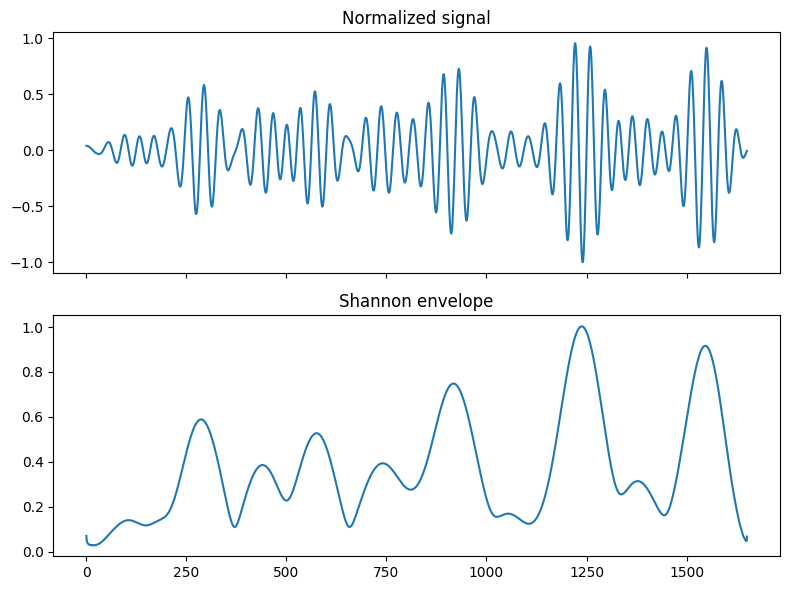

In [42]:
analytic_signal = sig.hilbert(normalized_signal)

# Calculate the absolute value of the analytic signal
envelope = np.abs(analytic_signal)

# Plot the original and envelope signals for comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

ax1.plot(normalized_signal)
ax1.set_title('Normalized signal')

ax2.plot(envelope)
ax2.set_title('Shannon envelope')

plt.tight_layout()
plt.show()

The code calculates the average energy of a signal in overlapping windows of a specified size using the Hilbert transform and Shannon envelope.

The first part of the code calculates the window size and overlap size in samples based on the example sample rate of 1000 Hz. The Hilbert transform is then applied to the normalized signal to obtain the analytic signal, which is used to calculate the Shannon envelope.

The next part of the code calculates the energy in each window by squaring the envelope and summing over each window. The energy is then divided by the window size to obtain the average energy in each window. The results are printed to the console

In [43]:
# Set window size and overlap
window_size = 0.02  # in seconds
overlap_size = 0.01  # in seconds

# Calculate window size and overlap in samples
sample_rate = 1000  # example sample rate in Hz
window_size_samples = int(window_size * sample_rate)
overlap_size_samples = int(overlap_size * sample_rate)

# Calculate the Hilbert transform of the signal
analytic_signal = sig.hilbert(normalized_signal)

# Calculate the absolute value of the analytic signal
envelope = np.abs(analytic_signal)

# Calculate the energy in each window
energy = np.zeros(len(normalized_signal))
for i in range(0, len(normalized_signal) - window_size_samples + 1, overlap_size_samples):
    energy[i:i+window_size_samples] = np.sum(envelope[i:i+window_size_samples]**2)

# Calculate the average energy in each window
average_energy = energy / window_size_samples

# Print the results
print(average_energy)

[0.00127735 0.00127735 0.00127735 ... 0.00863608 0.         0.        ]


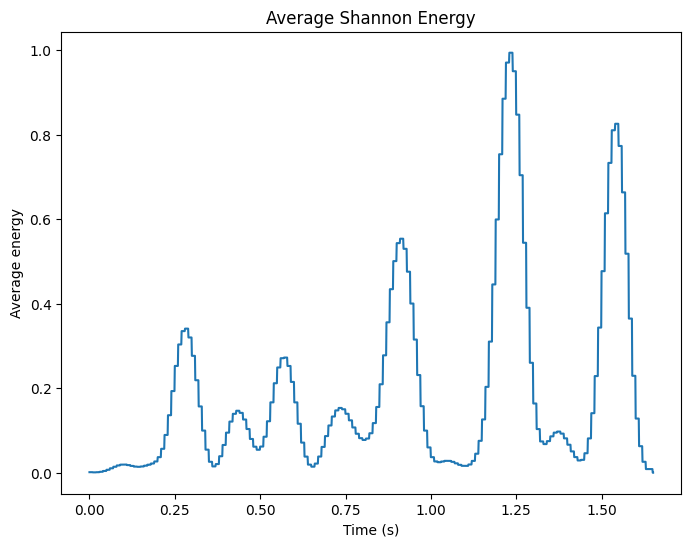

In [44]:
# Plot the average energy
time = np.arange(len(normalized_signal)) / sample_rate
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, average_energy)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average energy')
ax.set_title('Average Shannon Energy')
plt.show()

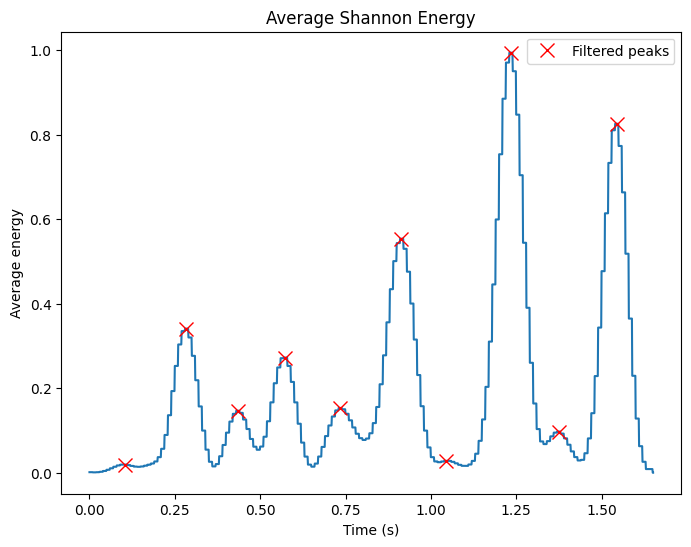

In [45]:
peaks, _ = sig.find_peaks(average_energy, distance=interval*1000/2)
# Filter peaks above 0.2
peak_values = average_energy[peaks]
peak_mask = peak_values >= 0
filtered_peaks = peaks[peak_mask]

# Plot the average energy and the filtered peaks
time = np.arange(len(average_energy)) / sample_rate
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time, average_energy)
ax.plot(time[filtered_peaks], average_energy[filtered_peaks], 'x', color='red', markersize=10, label='Filtered peaks')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average energy')
ax.set_title('Average Shannon Energy')
ax.legend()
plt.show()


Below is the generated output which we will verify this output with the 
corresponding S1, S2 values in the Btraining_normal_seg.csv file and by 
comparing the values in set_a and set_b, we will get to a conclusion that the heartbeat sounds took from the clinic gives less error compared to the iphone app. 


---



---


The segmentation is accomplished by using the envelope of Shannon energy and an algorithm for peak detection. Despite of the good performance for the correct detection of S1 and S2 sounds in the signal, we need to improve the criteria for identifying S1 and S2 (who is who)

In [46]:
filtered_peaks

array([ 104,  284,  434,  574,  734,  914, 1044, 1234, 1374, 1544])

# Importing Dataset

In [63]:
temp = pd.read_csv('/content/drive/MyDrive/Atraining_normal_seg.csv')
temp.head()
temp=temp.fillna(0)

In [64]:
# create training data
data_x = []
data_y = []
for j in range(temp.shape[0]):
   for i in range(1, temp.shape[1] - 1):
       data, sampling_rate = librosa.load('/content/drive/MyDrive/Atraining_normal (1)/Atraining_normal/'+ temp.iloc[j, 0].split('.')[0] +'.wav', sr=44100 )
       temp_data = data[int(temp.iloc[j, i]):int(temp.iloc[j, i+1])]
       temp_label = temp.iloc[:, i].name.split('.')[0]
 
       data_x.append(temp_data)
       data_y.append(temp_label)



Preprocessing

In [69]:
# preprocessing 
from keras.utils import pad_sequences

# step 1
data_x = pad_sequences(data_x, maxlen=20000, dtype='float', padding='post', truncating='post', value=0.)

# step 2
data_x = data_x / np.max(data_x)

# step 3
data_x = data_x[:,:,np.newaxis]
data_y = pd.Series(data_y)
data_y.value_counts()

data_y = data_y.map({'S1':0, 'S2':1}).values

Building the Model

In [73]:
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPool1D
from keras.models import Sequential

model = Sequential()

model.add(InputLayer(input_shape=data_x.shape[1:]))

model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Flatten())
model.add(Dense(units=1, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19991, 50)         550       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2499, 50)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2490, 50)          25050     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 312, 50)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 15600)             0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [74]:
model.fit(data_x, data_y, batch_size=32, epochs=1)

25/25 [==============================] - 28s 993ms/step - loss: 0.6900 - accuracy: 0.5000


In [75]:
df = pd.read_csv("/content/drive/MyDrive/Btraining_normal_seg.csv")
df.head()
df=temp.fillna(0)

In [76]:
# create training data
data_x = []
data_y = []
for j in range(df.shape[0]):
   for i in range(1, df.shape[1] - 1):
       data, sampling_rate = librosa.load('/content/drive/MyDrive/Atraining_normal (1)/Atraining_normal/'+ df.iloc[j, 0].split('.')[0] +'.wav', sr=44100 )
       df_data = data[int(df.iloc[j, i]):int(df.iloc[j, i+1])]
       df_label = df.iloc[:, i].name.split('.')[0]
 
       data_x.append(df_data)
       data_y.append(df_label)

In [77]:
# preprocessing 
from keras.utils import pad_sequences

# step 1
data_x = pad_sequences(data_x, maxlen=20000, dtype='float', padding='post', truncating='post', value=0.)

# step 2
data_x = data_x / np.max(data_x)

# step 3
data_x = data_x[:,:,np.newaxis]
data_y = pd.Series(data_y)
data_y.value_counts()

data_y = data_y.map({'S1':0, 'S2':1}).values

In [78]:
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPool1D
from keras.models import Sequential

model = Sequential()

model.add(InputLayer(input_shape=data_x.shape[1:]))

model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Flatten())
model.add(Dense(units=1, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 19991, 50)         550       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2499, 50)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 2490, 50)          25050     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 312, 50)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [79]:
model.fit(data_x, data_y, batch_size=32, epochs=1)

25/25 [==============================] - 26s 968ms/step - loss: 0.6912 - accuracy: 0.5000


We have acheieved a 50% accuracy for audio segmentation